# Check GPU

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Dec 18 17:51:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Run this command once and restart the runtime

In [ ]:
!pip install av

     |████████████████████████████████| 36.9MB 138kB/s 


# Mount drive


In [3]:
import os
import io
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/drive'

drive.mount(DRIVE_MOUNT)


# create folder to write data to
DATA_FOLDER = os.path.join(DRIVE_MOUNT, 'Shared drives', 'CIS680 Final Project', 'data')

Mounted at /content/drive


# Load Dataset

In [3]:
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
from torchvision import transforms
from torch import nn, Tensor
# from dataset import *
import random
import torchvision
import torchvision.models as models
import torch.optim as optim
import numpy as np

train_size = 138
test_size = 41

train_path = DATA_FOLDER + "/dataset_3/train/train_b"
test_path = DATA_FOLDER + "/dataset_3/test/test_b"

train_loader = []
test_loader = []

for batch in range(train_size):
    batch_path = train_path + str(batch) + ".pt"
    train_loader.append(torch.load(batch_path))
    if batch % 10 == 0:
        print("train: " + str(batch) + "/" + str(train_size))

for batch in range(test_size):
    batch_path = test_path + str(batch) + ".pt"
    test_loader.append(torch.load(batch_path))
    if batch % 10 == 0:
        print("test: " + str(batch) + "/" + str(test_size))


train: 0/138
train: 10/138
train: 20/138
train: 30/138
train: 40/138
train: 50/138
train: 60/138
train: 70/138
train: 80/138
train: 90/138
train: 100/138
train: 110/138
train: 120/138
train: 130/138
test: 0/41
test: 10/41
test: 20/41
test: 30/41
test: 40/41


# Spatial Model

In [4]:
class SpatialStream(torch.nn.Module):

    def __init__(self, 
                 device='cuda',
                 num_classes=51,
                 dropout_probability=0.5,
                 train_resnet=True):

        # Initialize the stream layers
        super(SpatialStream, self).__init__()
        self.device = device
        self.num_classes = num_classes

        # Spatial Backbone
        self.spatial = models.resnet50(pretrained=True)
        for param in self.spatial.parameters():
            param.requires_grad = train_resnet  # False: Freezes the weights of the pre-trained model

        # Add to Spatial Backbone
        self.spatial.fc = nn.Sequential(nn.Linear(2048, 1024),
                                nn.ReLU(),
                                nn.Dropout(p=dropout_probability),
                                nn.Linear(1024, self.num_classes),
                                nn.ReLU(),
                                nn.Dropout(p=dropout_probability),
                                nn.Softmax())

    def forward(self, X):
        return self.spatial(X)

    def compute_loss(self, output, labels):
        criterion = nn.CrossEntropyLoss()
        # labels = torch.tensor(labels)

        loss = criterion(output, labels)
        return loss

# Temporal Model

In [5]:
class TemporalStream(torch.nn.Module):

    def __init__(self,
                 device='cuda',
                 num_classes=51,
                 dropout_probability=0.5):

        # Initialize the stream layers
        super(TemporalStream, self).__init__()
        self.device = device
        self.num_classes = num_classes

        # Backbone
        self.temporal = models.resnet50(pretrained=True)
        for param in self.temporal.parameters():
            param.requires_grad = True

        #self.temporal.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3)

        self.temporal.fc = nn.Sequential(nn.Linear(2048, 1024),
                                nn.ReLU(),
                                nn.Dropout(p=dropout_probability),
                                nn.Linear(1024, self.num_classes),
                                nn.ReLU(),
                                nn.Dropout(p=dropout_probability),
                                nn.Softmax())
        

    def forward(self, X):
        X = self.temporal(X)
        return X

    def compute_loss(self, output, target):
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, target)
        return loss

# Fuse Model

In [37]:
class FuseNET(torch.nn.Module):

    def __init__(self, 
                 device='cuda',
                 num_classes=51):

        # Initialize the stream layers
        super(FuseNET, self).__init__()
        self.device = device
        self.num_classes = num_classes

        self.fc1 = nn.Linear(102, self.num_classes, bias=False)
        nn.init.constant_(self.fc1.weight, 0.5)
        #self.output = nn.Linear(204, self.num_classes)
        
        self.softmax = nn.Softmax()
        #self.relu = nn.ReLU()

    def forward(self, X):
        X = self.fc1(X)
        #X = self.relu(X)
        #X = self.output(X)
        X = self.softmax(X)
        return X

    def compute_loss(self, output, labels):
        criterion = nn.CrossEntropyLoss()
        # labels = torch.tensor(labels)

        loss = criterion(output, labels)
        return loss

# Video Frame Stacking (SG3I)

In [7]:
from google.colab.patches import cv2_imshow
import cv2 as cv

def getSG3I(videos):
    bz = videos.size(0)

    frame_list_batch = []

    for b in range(bz):
        images = videos[b]

        w = images[0].size(0)
        h = images[0].size(1)
        num_frames = images.size(0)
        frame_list = []

        for i in range(0, num_frames):
            frame_list.append(cv.cvtColor(images[i].numpy(), cv.COLOR_BGR2GRAY))

        frame_list_batch.append(np.stack(frame_list, axis=-1))

    SG3I = np.stack(frame_list_batch, axis=0)
    #cv2_imshow(SG3I[0])

    return torch.Tensor(SG3I)

# Train and Test Functions

In [42]:
  import random
  
  def train(epoch):
    spatial.eval()
    temporal.eval()
    fused.train()

    batch_iter = [0,64]
    counter = 0
    train_loss = 0
    log_interval = 100
    save_interval = 250

    epoch_loss = []
    log_int_loss = 0
    for iter, data in enumerate(train_loader, 0):
        for i in batch_iter:

          videos = data["videos"][0+i:i+64]
          labels = torch.tensor(data["labels"][0+i:i+64])
          indexes = data["indexes"][0+i:i+64]
          
          SG3I = getSG3I(videos)
          SG3I = SG3I.permute(0,3,1,2)
          SG3I = SG3I.to(device)

          videos = videos.type(torch.FloatTensor)
          videos = videos.to(device)
          # labels = labels.to(device)

          
          with torch.no_grad():
              # spatial
              pick = random.randint(0, 2)
              spatial_input = videos[:,pick,:,:].permute(0,3,1,2)
              spatial_output = spatial(spatial_input)

              # temporal        
              temporal_output = temporal(SG3I)
          
          optimizer.zero_grad()

          # fused
          fused_input = torch.hstack((spatial_output, temporal_output))
          fused_output = fused(fused_input)

          fused_output = fused_output.to(device)
          labels = labels.to(device)

          # calculate losses
          loss = fused.compute_loss(fused_output, labels)

          loss.backward()
          optimizer.step()
          train_loss += loss.item()

          # Logging Interval
          log_int_loss += loss.item()
          epoch_loss.append(loss.item())

          if counter == 0:
              print('Epoch: ', epoch, ', Batch: ', iter, ', loss avg over log interval: ', log_int_loss)
              train_loss_list.append(train_loss / (iter + 1) * batch_size)
              train_counter.append((iter + 1) * batch_size + epoch * 64)
              log_int_loss = 0
          elif counter % log_interval == log_interval - 1:
              print('Epoch: ', epoch, ', Batch: ', iter, ', loss avg over log interval: ', log_int_loss / log_interval)
              train_loss_list.append(train_loss / (iter + 1) * batch_size)
              train_counter.append((iter + 1) * batch_size + epoch * 64)
              log_int_loss = 0

          # if counter % save_interval == save_interval - 1:
          #     print('saving model')
          #     save_path = os.path.join(EPOCH_SAVE_PREFIX, 'fused_sampled_epoch' + str(epoch) + '_iter_' + str(counter))
          #     torch.save({
          #         'epoch': epoch,
          #         'train_total_loss_list': train_loss_list,
          #         'epoch_total_loss_list': epoch_loss_list,
          #         'test_loss_list': test_loss_list,
          #         'train_counter': train_counter,
          #         'accuracy_list': accuracy_list,
          #         'model_state_dict': fused.state_dict(),
          #         'optimizer_state_dict': optimizer.state_dict()
          #     }, save_path)

          counter += 1


    avg_loss = sum(epoch_loss) / len(epoch_loss)
    epoch_loss_list.append(avg_loss)
    print('Epoch: ', epoch, ', avg total loss: ', avg_loss)

def test():
    fused.eval()
    test_loss = 0
    correct = 0

    batch_iter = [0,64]
    # Data Loop
    with torch.no_grad():
        for iter, data in enumerate(test_loader, 0):
          for i in batch_iter:
            videos = data["videos"][0+i:i+64]
            labels = torch.tensor(data["labels"][0+i:i+64])
            indexes = data["indexes"][0+i:i+64]
            
            if len(videos) < 2:
              break
            SG3I = getSG3I(videos)
            SG3I = SG3I.permute(0,3,1,2)
            SG3I = SG3I.to(device)

            videos = videos.type(torch.FloatTensor)
            videos = videos.to(device)
            # labels = labels.to(device)

            # spatial
            spatial_input = videos[:,0,:,:].permute(0,3,1,2)
            spatial_output = spatial(spatial_input)

            # temporal        
            temporal_output = temporal(SG3I)
            
            # fused
            fused_input = torch.hstack((spatial_output, temporal_output))
            fused_output = fused(fused_input)

            fused_output = fused_output.to(device)
            labels = labels.to(device)

            # calculate losses
            loss = fused.compute_loss(fused_output, labels)

            test_loss += loss.item()

            # calculate number of correct predictions in batch
            correct += sum(torch.argmax(fused_output,1) == labels).item()
            if iter % 100 == 0:
                print ("iter  ", iter)
                print("accuracy so far = ", correct / ((iter + 1) * 128))

    # Log
    test_loss_list.append(test_loss / len(test_loader))
    accuracy = correct / (5145)
    accuracy_list.append(accuracy)
    print('Avg Validation Loss: ', test_loss / len(test_loader))
    print('Accuracy: ', accuracy)

# Main Training Loop

In [43]:
EPOCH_SAVE_PREFIX = '/content/drive/Shared drives/CIS680 Final Project/models/fused_sampled_3_relu_rahul_sgd/'

# Device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.random.manual_seed(1)

# load trained spatial
spatial = SpatialStream()
spatial.to(device)
spatial_network_path = '/content/drive/Shared drives/CIS680 Final Project/models/spatial_sampled_3/spatial_epoch445'
checkpoint_spatial = torch.load(spatial_network_path)
spatial.load_state_dict(checkpoint_spatial['model_state_dict'])

# load trained temporal
temporal = TemporalStream()
temporal.to(device)
temporal_network_path = '/content/drive/Shared drives/CIS680 Final Project/models/temporal_new_data/temporal_epoch288'
checkpoint_temporal = torch.load(temporal_network_path)
temporal.load_state_dict(checkpoint_temporal['model_state_dict'])


# fused model
learning_rate = 0.001
fused = FuseNET()
fused.to(device)
optimizer = optim.AdamW(fused.parameters(), lr=learning_rate)#, momentum=0.9)

# Epochs
num_epochs = 250
batch_size = 64

# Logging setup: train
train_loss_list = []
epoch_loss_list = []
train_counter = []

# Logging setup: test
test_loss_list = []
accuracy_list = []
epoch_list = np.arange(num_epochs)

# epoch loop
for epoch in range(num_epochs):

    # Train & Validate
    train(epoch)
    test()

    # Save Model Version
    save_path = os.path.join(EPOCH_SAVE_PREFIX, 'fused_sampled_epoch' + str(epoch))
    torch.save({
        'epoch': epoch,
        'train_total_loss_list': train_loss_list,
        'epoch_total_loss_list': epoch_loss_list,
        'test_loss_list': test_loss_list,
        'train_counter': train_counter,
        'accuracy_list': accuracy_list,
        'model_state_dict': fused.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, save_path)

    print("Epoch %d/%d Completed" % (epoch, num_epochs - 1))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch:  0 , Batch:  0 , loss avg over log interval:  3.931824207305908
Epoch:  0 , Batch:  49 , loss avg over log interval:  3.889885129928589
Epoch:  0 , Batch:  99 , loss avg over log interval:  3.922495193481445
Epoch:  0 , avg total loss:  3.92252820039141
iter   0
accuracy so far =  0.4765625
iter   0
accuracy so far =  0.765625
Avg Validation Loss:  7.7456827745205015
Accuracy:  0.5172011661807581
Epoch 0/249 Completed
Epoch:  1 , Batch:  0 , loss avg over log interval:  3.906594753265381
Epoch:  1 , Batch:  49 , loss avg over log interval:  3.8618234610557556
Epoch:  1 , Batch:  99 , loss avg over log interval:  3.8784245920181273
Epoch:  1 , avg total loss:  3.8777425980222398
iter   0
accuracy so far =  0.484375
iter   0
accuracy so far =  0.7734375
Avg Validation Loss:  7.681601576688813
Accuracy:  0.5327502429543246
Epoch 1/249 Completed
Epoch:  2 , Batch:  0 , loss avg over log interval:  3.8162405490875244
Epoch:  2 , Batch:  49 , loss avg over log interval:  3.76381967306

# Resume Training

In [32]:
EPOCH_SAVE_PREFIX = '/content/drive/Shared drives/CIS680 Final Project/models/fused_sampled_3_relu_rahul_sgd/'

# Device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.random.manual_seed(1)

# load trained spatial
spatial = SpatialStream()
spatial.to(device)
spatial_network_path = '/content/drive/Shared drives/CIS680 Final Project/models/spatial_sampled_3/spatial_epoch445'
checkpoint_spatial = torch.load(spatial_network_path)
spatial.load_state_dict(checkpoint_spatial['model_state_dict'])

# load trained temporal
temporal = TemporalStream()
temporal.to(device)
temporal_network_path = '/content/drive/Shared drives/CIS680 Final Project/models/temporal_new_data/temporal_epoch288'
checkpoint_temporal = torch.load(temporal_network_path)
temporal.load_state_dict(checkpoint_temporal['model_state_dict'])


# fused model
learning_rate = 0.001
fused = FuseNET()
fused.to(device)
optimizer = optim.SGD(fused.parameters(), lr=learning_rate, momentum=0.9)

# Epochs
num_epochs = 1000
batch_size = 64
epoch_list = np.arange(num_epochs)


# LOAD NETWORK
fused_network_path = EPOCH_SAVE_PREFIX + 'fused_sampled_epoch7'
checkpoint_fused = torch.load(fused_network_path)
fused.load_state_dict(checkpoint_fused['model_state_dict'])
#optimizer.load_state_dict(checkpoint_fused['optimizer_state_dict'])
last_epoch = checkpoint_fused['epoch']

# Logging setup: train
train_loss_list = checkpoint_fused['train_total_loss_list']
epoch_loss_list = checkpoint_fused['epoch_total_loss_list']

test_loss_list = checkpoint_fused['test_loss_list']
accuracy_list = checkpoint_fused['accuracy_list']
train_counter = checkpoint_fused['train_counter']


# epoch loop
for epoch in range(last_epoch + 1, num_epochs):

    # Train & Validate
    train(epoch)
    test()

    # Save Model Version
    save_path = os.path.join(EPOCH_SAVE_PREFIX, 'fused_sampled_epoch' + str(epoch))
    torch.save({
        'epoch': epoch,
        'train_total_loss_list': train_loss_list,
        'epoch_total_loss_list': epoch_loss_list,
        'test_loss_list': test_loss_list,
        'train_counter': train_counter,
        'accuracy_list': accuracy_list,
        'model_state_dict': fused.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, save_path)

    print("Epoch %d/%d Completed" % (epoch, num_epochs - 1))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch:  8 , Batch:  0 , loss avg over log interval:  3.017577648162842
Epoch:  8 , Batch:  49 , loss avg over log interval:  3.016844239234924
Epoch:  8 , Batch:  99 , loss avg over log interval:  3.0447605061531067
Epoch:  8 , avg total loss:  3.044150179710941
iter   0
accuracy so far =  0.953125
iter   0
accuracy so far =  1.40625
Avg Validation Loss:  6.836523788731273
Accuracy:  0.506859756097561
Epoch 8/999 Completed
Epoch:  9 , Batch:  0 , loss avg over log interval:  3.018711566925049
Epoch:  9 , Batch:  49 , loss avg over log interval:  3.013567569255829
Epoch:  9 , Batch:  99 , loss avg over log interval:  3.0438222742080687
Epoch:  9 , avg total loss:  3.042521598546401
iter   0
accuracy so far =  0.953125
iter   0
accuracy so far =  1.40625
Avg Validation Loss:  6.836684994581269
Accuracy:  0.5072408536585366
Epoch 9/999 Completed
Epoch:  10 , Batch:  0 , loss avg over log interval:  3.01759934425354
Epoch:  10 , Batch:  49 , loss avg over log interval:  3.0166345405578614


KeyboardInterrupt: ignored

# Plotting

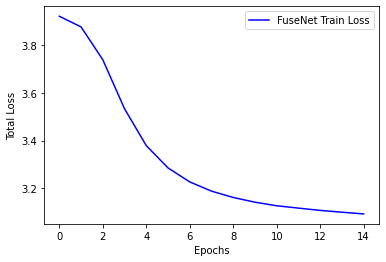

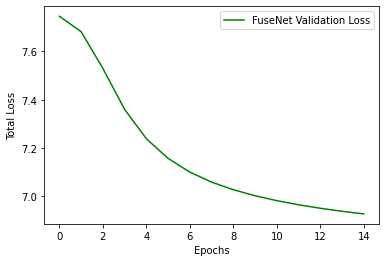

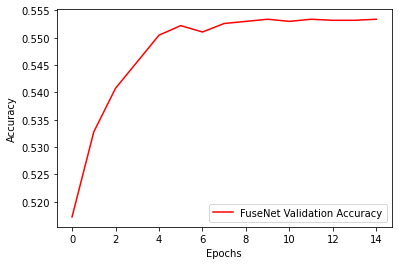

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt


EPOCH_SAVE_PREFIX = '/content/drive/Shared drives/CIS680 Final Project/models/fused_sampled_3_relu_rahul_sgd/'

# Device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.random.manual_seed(1)

# Load params
last_epoch = 14

# load data
network_path = EPOCH_SAVE_PREFIX + 'fused_sampled_epoch' + str(last_epoch)
checkpoint = torch.load(network_path)
train_loss_list = checkpoint['train_total_loss_list']
epoch_loss_list = checkpoint['epoch_total_loss_list']
train_counter = checkpoint['train_counter']
test_loss_list = checkpoint['test_loss_list']
accuracy_list = checkpoint['accuracy_list']
epoch_list = np.arange(last_epoch+1)


# plots
fig = plt.figure()
plt.plot(epoch_loss_list, color='blue')
plt.legend(['FuseNet Train Loss'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Total Loss')

fig = plt.figure()
plt.plot(test_loss_list, color='green')
plt.legend(['FuseNet Validation Loss'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Total Loss')

fig = plt.figure()
plt.plot(accuracy_list, color='red')
plt.legend(['FuseNet Validation Accuracy'], loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


plt.show()